# Siamese architecture

In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../data_processing/')
from siamese_data import MNIST # load the data and process it
%matplotlib inline

## The data set: MNIST
Let's have a look at the MNIST data set. The MNIST data set is a labeled data set consisting in 70,000 handwritten digits (see http://yann.lecun.com/exdb/mnist/ for more information). It is often used to benchmarck classification algorithms.

Below we show some images from MNIST.

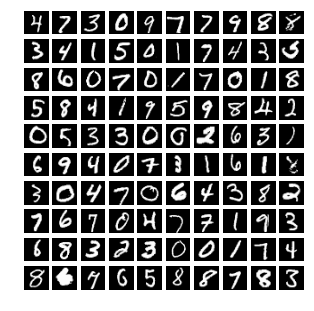

In [2]:
data = MNIST() # load the data
examples_n = 100 # display some images
indexes = np.random.choice(range(len(data.y)), examples_n, replace=False)
fig = plt.figure(figsize=(5,5))
for i in range(1, examples_n + 1):
    a = fig.add_subplot(np.sqrt(examples_n), np.sqrt(examples_n), i)
    a.axis('off')
    image = data.x[indexes[i-1]].reshape((28, 28)) # reshape the image from (784) to (28, 28).
    a.imshow(image, cmap='Greys_r');

## Siamese network

A *siamese network* is a network consisting in two identical (hence the name) neural networks with tied weights (the weights of the two networks are the same). Given two inputs $X_1$ and $X_2$, $X_1$ is fed to the first network and $X_2$ to the second network. Then, the outputs from the two networks are combined and produce an answer to the question: **are the two inputs similar or different?**

For more details regarding siamese networks, we refer the interested reader to the paper that introduced siamese networks in 1993: *Signature Verification using a "Siamese" Time Delay Neural Network* (Bromley and Le Cun).

### Training hyperparameters

We define some hyperparameters related to the training of the network.

In [3]:
max_iter = 1000 # maximum number of iterations for training
learning_rate = 0.001
batch_train = 128 # batch size for training
batch_test = 512 # batch size for testing
display = 50 # display the training loss and accuracy every `display` step
n_test = 200 # test the network every `n_test` step

### Architecture of the siamese network

The two networks of the siamese architecture can be any suitable type of networks. Here, we use a simple bi-directional LSTM (it could have been a multilayer convolutional neural networks for instance).

An image from MNIST is a $28\times28$ image, thus we naturally consider an image as a sequence of $28$ row (or column) vectors of shape $(1, 28)$ (or $(28, 1)$).

In [4]:
n_inputs = 28 # dimension of each of the input vectors
n_steps = 28 # sequence length
n_hidden = 128 # number of neurons of the bi-directional LSTM
n_classes = 2 # two possible classes, either `same` of `different`

We create two placeholders to feed the data to the siamese network. $x_1$ will be fed to the first network and $x_2$ to the second network. We also define a dropout probability for the LSTMs to avoir overfitting. The dropout may slow down the training process but improves the generalization power of the model.

In [5]:
x1 = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs]) # placeholder for the first network (image 1)
x2 = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs]) # placeholder for the second network (image 2)

# placeholder for the label. `1` for `same` and `0` for `different`.
y = tf.placeholder(tf.int64, shape=[None])

# placeholder for dropout (we could use different dropout for different part of the architecture)
keep_prob = tf.placeholder(tf.float32)

We need to reshape the inputs so that they match the requirements of the TensorFlow function `tf.nn.bidirectional_rnn`.

In [6]:
def reshape_input(x_):
    """
    Reshape the inputs to match the shape requirements of the function
    `tf.nn.bidirectional_rnn`
    
    Args:
        x_: a tensor of shape `(batch_size, n_steps, n_inputs)`
        
    Returns:
        A `list` of length `n_steps` with its elements being tensors of shape `(batch_size, n_inputs)`
    """
    x_ = tf.transpose(x_, [1, 0, 2]) # shape: (n_steps, batch_size, n_inputs)
    x_ = tf.split(0, n_steps, x_) # a list of `n_steps` tensors of shape (1, batch_size, n_steps)
    return [tf.squeeze(z, [0]) for z in x_] # remove size 1 dimension --> (batch_size, n_steps)


x1_, x2_ = reshape_input(x1), reshape_input(x2)

We now create the bidirectional LSTM's cells that we'll use for our LSTM. A bidirectional LSTM consists of a forward cell and a backward cell. The two cells are independent.

In [7]:
lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True) # Forwward cell
lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True) # Backward cell

We add dropout to the LSTM cells.

In [8]:
lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_fw_cell, output_keep_prob=keep_prob)
lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_bw_cell, output_keep_prob=keep_prob)

We now create the siamese network. Note that we reuse the variables (weights) from the first network for the second network using the command `reuse_variables()`.

In [9]:
with tf.variable_scope('siamese_network') as scope:
    with tf.name_scope('Bi_LSTM_1'):
        _, last_state_fw1, last_state_bw1 = tf.nn.bidirectional_rnn(
                                        lstm_fw_cell, lstm_bw_cell, x1_,
                                        dtype=tf.float32)
    with tf.name_scope('Bi_LSTM_2'):
        scope.reuse_variables() # tied weights (reuse the weights from `Bi_LSTM_1` for `Bi_LSTM_2`)
        _, last_state_fw2, last_state_bw2 = tf.nn.bidirectional_rnn(
                                        lstm_fw_cell, lstm_bw_cell, x2_,
                                        dtype=tf.float32)

We connect the states from the two parts of the siamese network to compare them. More precisely, we compute the absolute difference between the states from the first network and the second network. We expect the difference to be small when the inputs are similar, and large otherwise.

In [10]:
# Weights and biases for the layer that connects the outputs from the two networks
weights = tf.get_variable('weigths_out', shape=[4 * n_hidden, n_classes],
                initializer=tf.random_normal_initializer(stddev=1.0/float(n_hidden)))
biases = tf.get_variable('biases_out', shape=[n_classes])

# We concatenate the states of the first network
last_state1 = tf.concat(1, [last_state_fw1[0], last_state_bw1[0],
                              last_state_fw1[1], last_state_bw1[1]])
# We concatenate the states of the second network
last_state2 = tf.concat(1, [last_state_fw2[0], last_state_bw2[0],
                              last_state_fw2[1], last_state_bw2[1]])
last_states_diff = tf.abs(last_state1 - last_state2)
logits = tf.matmul(last_states_diff, weights) + biases

We create the loss function along with the optimizer.

In [11]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), y) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

We now train the network.

In [12]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init) # initialize all variables
    print('Network training begins.')
    for i in range(1, max_iter + 1):
        # We retrieve a batch of data from the training set
        batch_x1, batch_x2, batch_y = data.get_next_batch(batch_train, phase='train')
        # We feed the data to the network for training
        feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: .9}
        _, loss_, accuracy_ = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
        
        if i % display == 0:
            print('step %i, training loss: %.5f, training accuracy: %.3f' % (i, loss_, accuracy_))
        
        # Testing the network
        if i % n_test == 0:
            # Retrieving data from the test set
            batch_x1, batch_x2, batch_y = data.get_next_batch(batch_test, phase='test')
            feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: 1.0}
            accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
            print('testing step %i, accuracy %.3f' % (i, accuracy_test))
    print('********************************')
    print('Training finished.')
    
    # testing the trained network on a large sample
    batch_x1, batch_x2, batch_y = data.get_next_batch(10000, phase='test')
    feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob:1.0}
    accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
    print('********************************')
    print('Testing the network.')
    print('Network accuracy %.3f' % (accuracy_test))
    print('********************************')

Network training begins.
step 50, training loss: 0.55436, training accuracy: 0.734
step 100, training loss: 0.53840, training accuracy: 0.742
step 150, training loss: 0.44149, training accuracy: 0.789
step 200, training loss: 0.40941, training accuracy: 0.812
testing step 200, accuracy 0.811
step 250, training loss: 0.38118, training accuracy: 0.844
step 300, training loss: 0.36554, training accuracy: 0.852
step 350, training loss: 0.27817, training accuracy: 0.875
step 400, training loss: 0.31239, training accuracy: 0.852
testing step 400, accuracy 0.871
step 450, training loss: 0.27546, training accuracy: 0.898
step 500, training loss: 0.31431, training accuracy: 0.875
step 550, training loss: 0.31289, training accuracy: 0.859
step 600, training loss: 0.39040, training accuracy: 0.828
testing step 600, accuracy 0.867
step 650, training loss: 0.27817, training accuracy: 0.883
step 700, training loss: 0.23682, training accuracy: 0.938
step 750, training loss: 0.23463, training accuracy